<a href="https://colab.research.google.com/github/dhirajsuvarna/nlp_text_classification/blob/master/hackathon/ULMFit_Drug_Review_Classification_Try_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading DataSet from Google Drive

In [1]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.text import * 

#Load the Traning and Validation Dataset
df_train = pd.read_csv('/content/drive/My Drive/Projects/AnalyticsHackathon/dataset/drugsComTrain_raw.csv')
df_valid = pd.read_csv('/content/drive/My Drive/Projects/AnalyticsHackathon/dataset/drugsComTest_raw.csv')

##Removing Empty Cells and Invalid Cells





In [4]:
df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#print(df_train[df_train['condition'].isna()])
print(f"#NaN in Train: {df_train[df_train['condition'].isna()].shape}")
print(f"#NaN in Validation: {df_valid[df_valid['condition'].isna()].shape}")

#Reomve the rows with empty(nan) 'condition' or empty(nan) 'review'
print("Removing rows with nan values...")
df_train = df_train.dropna()
df_valid = df_valid.dropna()

#print(df_train[df_train['condition'].str.contains('users found this comment helpful')])
print(f"#'users found this comment useful' in Train: {df_train[df_train['condition'].str.contains('users found this comment helpful')].shape}")
print(f"#'users found this comment useful'in Validation: {df_valid[df_valid['condition'].str.contains('users found this comment helpful')].shape}")

#Remove the rows where 'condition' is "users found this comment helpful"
print("Removing the rows where condition is 'users found this comment helpful'")
df_train = df_train[~df_train['condition'].str.contains('users found this comment helpful')]
df_valid = df_valid[~df_valid['condition'].str.contains('users found this comment helpful')]

df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#Train Examples: (161297, 2)
#Validation Examples: (53766, 2)
#NaN in Train: (899, 2)
#NaN in Validation: (295, 2)
Removing rows with nan values...
#'users found this comment useful' in Train: (900, 2)
#'users found this comment useful'in Validation: (271, 2)
Removing the rows where condition is 'users found this comment helpful'
#Train Examples: (159498, 2)
#Validation Examples: (53200, 2)


##Making the Traning Set Smaller for Quick Experiments

In [0]:
# #Creating a smaller version of dataset for quick setup of framework
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_valid = df_valid.sample(frac=1).reset_index(drop=True)

# df_train = df_train[:1000]
# df_valid = df_valid[:200]
# print(df_train.shape)
# print(df_valid.shape)


##Remove Mismatch of Classes between Validation and Training Set

In [5]:
#Number of classes present in the training and validation set
targets_train = df_train['condition'].unique()
targets_valid = df_valid['condition'].unique()
print(f"#Target Classes in Train: {len(targets_train)}")
print(f"#Target Classes in Validation: {len(targets_valid)}")

targets_only_in_valid = [item for item in targets_valid if item not in targets_train]
print(f"#Targets in Validation but not in Training: {len(targets_only_in_valid)}")


#Target Classes in Train: 811
#Target Classes in Validation: 664
#Targets in Validation but not in Training: 25


In [6]:
#Remove the items from Validation Set for which classes are present in Validation but not present in the Training Set
print(f"#Invalid Validation examples: {df_valid[df_valid['condition'].isin(targets_only_in_valid)].shape}")

df_valid = df_valid[~df_valid['condition'].isin(targets_only_in_valid)]

df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#Invalid Validation examples: (39, 2)
#Train Examples: (159498, 2)
#Validation Examples: (53161, 2)


In [7]:
#Check the Classes which are present in the Training Set but not present in the Validation Set
targets_only_in_train = [item for item in targets_train if item not in targets_valid]
print(f"#Targets in Training but not in Validation: {len(targets_only_in_train)}")

df_only_in_train = df_train[df_train['condition'].isin(targets_only_in_train)]
print(f"Training Examples only in Training Set: {df_only_in_train.shape}")

#print(df_only_in_train['condition'].value_counts())

#Targets in Training but not in Validation: 172
Training Examples only in Training Set: (419, 2)


In [8]:
#We can see that there are 419 Training examples for which 172 classes are present in Traning set but not the validation set
#To make the Traning and Validation Set Balanced, removing those 419 Traning Examples 
df_train = df_train[~df_train['condition'].isin(targets_only_in_train)]

df_train = df_train[['condition', 'review']]
df_valid = df_valid[['condition', 'review']]
print (f"#Train Examples: {df_train.shape}")
print (f"#Validation Examples: {df_valid.shape}")

#Train Examples: (159079, 2)
#Validation Examples: (53161, 2)


##Cleaning up Review Comments

In [0]:
#Perform basic cleaning operation on the review comments 
#mainly to convert the HTML Code Characters to the actual charcters
import html

# #SAVE TO CSV to see the changes with ur naked eyes
# df_train['clean_review'] = df_train['review'].apply(html.unescape)
# df_valid['clean_review'] = df_valid['review'].apply(html.unescape)
# df_train.to_csv('./drugsComTrainClean_raw.csv')
# df_train.to_csv('./drugsComTestClean_raw.csv')

df_train['review'] = df_train['review'].apply(html.unescape)
df_valid['review'] = df_valid['review'].apply(html.unescape)

#print(df_train[df_train['condition'] == "Depression"])


##Summary of the Data

In [10]:
print (f"Shape of Cleaned up Train Set: {df_train.shape}")
print (f"Shape of Cleaned up  Validation Set: {df_valid.shape}")

#Number of classes present in the training and validation set
targets_train = df_train['condition'].unique()
targets_valid = df_valid['condition'].unique()
print(f"#Target Classes in Train: {len(targets_train)}")
print(f"#Target Classes in Validation: {len(targets_valid)}")


Shape of Cleaned up Train Set: (159079, 2)
Shape of Cleaned up  Validation Set: (53161, 2)
#Target Classes in Train: 639
#Target Classes in Validation: 639


##Visualizing the Data
(not so visual for now)

In [11]:
#Visualize the dataspread for each of the classes 
#print(df_train.groupby(['condition']).size().reset_index(name='count').sort_values(['count'], ascending=False))
print(df_train['condition'].value_counts())
print(df_valid['condition'].value_counts())

Birth Control                         28788
Depression                             9069
Pain                                   6145
Anxiety                                5904
Acne                                   5588
                                      ...  
Acetaminophen Overdose                    1
Epididymitis, Sexually Transmitted        1
Gonadotropin Inhibition                   1
Acute Nonlymphocytic Leukemia             1
Subarachnoid Hemorrhage                   1
Name: condition, Length: 639, dtype: int64
Birth Control                                   9648
Depression                                      3095
Pain                                            2100
Anxiety                                         1908
Acne                                            1847
                                                ... 
Stress Ulcer Prophylaxis                           1
Urinary Retention                                  1
Reversal of Nondepolarizing Muscle Relaxants     

##Start ULMFit Stuff

In [12]:
#Adding a column "is_valid" to determine example belongs to validation set of not
df_train['is_valid'] = 0
df_valid['is_valid'] = 1

#combine two dataframe into one
df_combine = pd.concat([df_train, df_valid], axis=0)

print(df_combine.shape)

(212240, 3)


In [0]:

bs,bptt=64,80

In [0]:
#Prepare for training the language model
#todo: i have not specified batch size(bs)
#data_lm = TextLMDataBunch.from_df(path='/', train_df=df_train, valid_df=df_valid)
#learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

data_lm = (TextList.from_df(df_combine, cols='review')
            .split_from_df(col='is_valid')
            .label_for_lm()
            .databunch(bs=bs, bptt=bptt))
data_lm.save('data_lm.pkl')


In [0]:
path = '.'
data_lm = load_data(path, 'data_lm.pkl', bs=bs, bptt=bptt)

In [16]:
data_lm.show_batch()

idx,text
0,", and slept for nearly 8 hours on a drive home from school vacation ( very unusual for him . ) i called his doctor on xxmaj monday morning and she said to stick it out a few days . xxmaj see how he did at school , and with getting up in the morning . xxmaj the last two days have been problem free . xxmaj he is xxup"
1,"30 minutes i was in emergency room with anaphylactic shock . i do n't remember much of anything till i woke up the next morning and was told how bad it almost was for me . i take 8 statins to maintain a cholesterol of 200 . "" xxbos "" i went 5 miserable years with undiagnosed , xxmaj hashimoto disease for which i was told it was all in"
2,"baggy . xxmaj lots of energy . i slightly started to want to eat . 3rd month . xxmaj total xxunk 28 lbs . "" xxbos "" xxmaj prescribed 500 mg 3x a day for xxup bv . xxmaj day 1 i took two doses 8 hours apart . xxmaj awful , chalky taste that you ca n't get rid of . xxmaj slight dizzyness and slight headache day 1"
3,""" i love this birth control . i switched from xxmaj lo loestrin xxup fe because i would get two periods on that ( one in week 2 of active pills and one during the placebos ) and my doctor said i needed to up my estrogen dose . i was so nervous to start this because of various negative reviews , but i 'm almost finished with my first"
4,"amitriptyline for 2 months and i have only one side effect - dry cough occasionally . i suffered from migraines from childhood and first my doctor tried a blood pressure medicine that also treats migraines . xxmaj while somewhat effective , i still had headaches and migraines after 1 - 2 months , up to 3 - 5 per week . xxmaj once he put me on xxmaj amitriptyline ,"


In [0]:
data_lm_bwd = load_data(path, 'data_lm.pkl', bs=bs, bptt=bptt, backwards=True)

In [0]:
learn_fwd = language_model_learner(data_lm, AWD_LSTM).to_fp16(clip=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


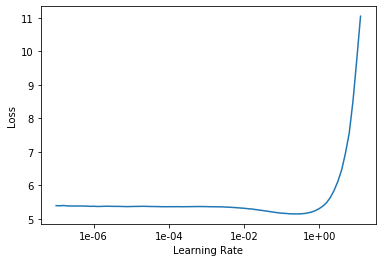

In [19]:
#find the learning rate 
learn_fwd.lr_find(start_lr=1e-8, end_lr=1e2)
learn_fwd.recorder.plot()

In [20]:
#The above plot tells us that loss is minimum at the learning rate of 
#approx 1e0, so we need to choose the learning rate as one level before

#Start training the language model
learn_fwd.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))



epoch,train_loss,valid_loss,accuracy,time
0,3.876233,3.584221,0.299675,09:27


In [21]:
learn_fwd.unfreeze()
learn_fwd.fit_one_cycle(3, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.350721,3.181236,0.348771,11:17
1,3.207137,3.039823,0.365956,11:15
2,3.129826,3.001792,0.371102,11:15


In [0]:
#Plot the curves for language model - if necessary


In [22]:
#See how the language model is doing on the statement of medical review 
#write some string
medical_review = "I have been continuing this medicine for the last couple of months but"
learn_fwd.predict(medical_review, n_words=10)

'I have been continuing this medicine for the last couple of months but i had a terrible time with the medication .'

In [0]:
#fine tuned language model is called as encoder - we need to save it
learn_fwd.save_encoder('fwd_enc')

In [0]:
learn_bwd = language_model_learner(data_lm_bwd, AWD_LSTM).to_fp16(clip=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


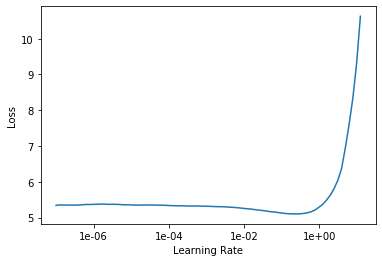

In [25]:
#find the learning rate 
learn_bwd.lr_find(start_lr=1e-8, end_lr=1e2)
learn_bwd.recorder.plot()

In [26]:
learn_bwd.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.866795,3.584870,0.350893,09:26


In [27]:
learn_bwd.unfreeze()
learn_bwd.fit_one_cycle(3, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.375104,3.187178,0.394815,11:17
1,3.216107,3.045416,0.410675,11:17
2,3.126726,3.008050,0.415447,11:18


In [0]:
learn_bwd.save_encoder('bwd_enc')

In [29]:
#See how the language model is doing on the statement of medical review 
#write some string
medical_review = "I have been continuing this medicine for the last couple of months but"
learn_bwd.predict(medical_review, n_words=10)

'I have been continuing this medicine for the last couple of months but yet for account to effects side apparent no noticed'

#Classifer

In [0]:
#Prepare for training the classifier
bs = 64
data_clas = (TextList.from_df(df_combine, cols='review')
              .split_from_df(col='is_valid')
              .label_from_df(cols='condition')
              .databunch(bs=bs))
data_clas.save('data_clas.pkl')


In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
#data_clas.show_batch()

In [0]:

#data_clas_bwd.show_batch()

In [33]:
learn_clas_fwd = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_clas_fwd.load_encoder('fwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (159079 items)
x: TextList
xxbos " xxmaj it has no side effect , i take it in combination of xxmaj bystolic 5 xxmaj mg and xxmaj fish xxmaj oil ",xxbos " xxmaj my son is halfway through his fourth week of xxmaj intuniv . xxmaj we became concerned when he began this last week , when he started taking the highest dose he will be on . xxmaj for two days , he could hardly get out of bed , was very cranky , and slept for nearly 8 hours on a drive home from school vacation ( very unusual for him . ) i called his doctor on xxmaj monday morning and she said to stick it out a few days . xxmaj see how he did at school , and with getting up in the morning . xxmaj the last two days have been problem free . xxmaj he is xxup much more agreeable than ever . xxmaj he is less emotional ( a good thing ) , less cranky . xxmaj he is remembering all the things he should . xxmaj overall his behavior is better . 
 
  xxmaj we have tried many different medi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


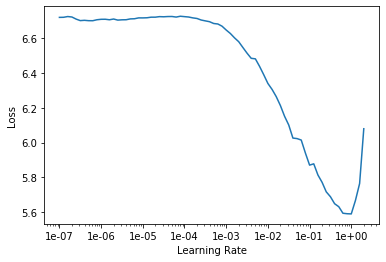

In [34]:
#find learning rate before starting the training of classifier
learn_clas_fwd.lr_find(start_lr=1e-8, end_lr=1e2)
learn_clas_fwd.recorder.plot()

In [35]:
#Start Training of the classifier 
# For training the classifier, "gradual unfreezing" should be applied to avoid "catastrophic forgetting"
# as explained in section 3.3 of Howard and Ruder's paper - https://arxiv.org/pdf/1801.06146.pdf 

learn_clas_fwd.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.944084,1.727961,0.606196,03:56


In [36]:
learn_clas_fwd.freeze_to(-2)
learn_clas_fwd.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.518614,1.386487,0.659149,04:52


In [37]:
learn_clas_fwd.freeze_to(-3)
learn_clas_fwd.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.560958,1.260370,0.686481,07:58


In [38]:
learn_clas_fwd.unfreeze()
learn_clas_fwd.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.424356,1.234510,0.692613,09:48
1,1.262495,1.176599,0.706928,10:03
2,1.264239,1.144952,0.714866,09:53
3,1.083277,1.133738,0.716390,10:22


In [40]:
learn_clas_fwd.fit_one_cycle(6, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.174745,1.109200,0.724610,09:10
1,1.091042,1.077634,0.731156,10:30
2,0.928951,0.978015,0.759410,09:43
3,0.775227,0.892272,0.786592,08:50
4,0.606248,0.836694,0.811836,10:20
5,0.520911,0.834858,0.816200,09:43


In [41]:
learn_clas_fwd.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.664672,0.892523,0.796881,09:41
1,0.543265,0.821861,0.823367,09:23


In [42]:
learn_clas_fwd.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.649799,0.863744,0.810575,09:25
1,0.501957,0.800210,0.834653,09:46


In [0]:
#Export the Learned Model
learn_clas_fwd.export('/content/drive/My Drive/Projects/AnalyticsHackathon/learned_classifer_try_2_fwd.pkl')

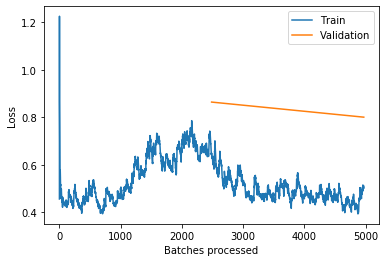

In [44]:
#Plot the curves for classifer model - should be done
learn_clas_fwd.recorder.plot_losses()

In [45]:
#Show Results: Acutal and Predicted 
learn_clas_fwd.show_results(rows=10 )


text,target,prediction
"xxbos "" i do n’t find a lot of positive stories about antidepressants , or i find stories where people are taking the antidepressant the wrong way . \r \n \r \n i wanted to share my experience . a positive one . \r \n \r \n i ’ve had generalized anxiety disorder , xxup severe xxup ocd , and panic disorder for as long as i can",Obsessive Compulsive Disorde,Obsessive Compulsive Disorde
"xxbos "" • \t 19 xxmaj apr. 2016 \r\r \n \r\r \n xxmaj began initial dose at xxunk hours . xxmaj felt the medicine working within a ½ hour . xxmaj was in a good mood as i had been taken off of xxmaj warfarin this date . xxmaj before drifting off to sleep , i xxunk at the clock . xxmaj it was approx . xxunk hrs .",Depression,Constipation
"xxbos "" xxmaj my personal experience with suboxone is good so far . i have been on prescribed xxmaj fentanyl xxmaj patch 25 much / 48 hrs . i have dropped to this dose over the last year . ( i also left the old patch on ) . i have been on opiates for 12 years full time prescribed . xxmaj at my highest prescription i was using 180",Opiate Dependence,Opiate Dependence
"xxbos "" xxmaj my personal experience with suboxone is good so far . i have been on prescribed xxmaj fentanyl xxmaj patch 25 much / 48 hrs . i have dropped to this dose over the last year . ( i also left the old patch on ) . i have been on opiates for 12 years full time prescribed . xxmaj at my highest prescription i was using 180",Opiate Dependence,Opiate Dependence
"xxbos "" xxmaj my colonoscopy was booked in for late afternoon on a xxmaj thursday . xxmaj the hospital said to stop eating anything from 1 pm on the xxmaj wednesday and recommended ( giving some detail ) a non fibre diet from xxmaj tuesday evening until xxmaj wednesday noon - avoiding dark drinks and jelly ( like xxunk flavour ) . xxmaj avoid red meat , sausages and pies",Bowel Preparation,Bowel Preparation
"xxbos "" xxmaj holy xxunk xxmaj batman it worked ! xxmaj but boy it was a xxmaj journey lol for 4 days i had n't pooped ! i had already taken laxatives , stool softener , a bucket of prunes , fiber pills , other fiber pills and still no poop over the last 4 days ! xxmaj so i called friend that has xxmaj gastroparesis and asked her what",Constipation,Constipation
"xxbos "" i just started this medicine 3 days ago and i can not express how much of an effect it has had on me already . i just graduated high school and became depressed soon after , severe anxiety where i could n't go out to eat without having to vomit . i also could n't keep focus on anything , especially when trying to talk to people ,",Depression,Depression
"xxbos "" i felt compelled to write a review , as i was on topamax ( or should i say dopamax ? ! ) for about 2 years . i started this medication when i was 21 and was so desperate to find something that would actually help my on - going migraines . xxmaj personally , the side effect symptoms xxup far outweighed the benefits . i started out",Migraine Prevention,Migraine Prevention
"xxbos "" i have dealt with ups and downs , anxiety , social anxiety , depression etc . etc . for years . xxmaj my life overall is normal and i managed the episodes but i always knew they were there and did n't like feeling that way . i am married we have children combine that with everything else and it times it was just too much . xxmaj",Social Anxiety Disorde,Social Anxiety Disorde
"xxbos "" xxmaj yes , this medication works . xxmaj it works very well for chronic anxiety disorder and sudden xxunk of severe panic attacks . xxmaj knowing what i know now , i wish with all my being it had never ever been prescribed to me , and without the absurd xxunk dozens of practitioners have portrayed . \r\r \n i 'm 32 and have been prescribed clonazopam",Anxiety,Anxiety


#Train backward classifer

In [0]:
data_clas_bwd = load_data(path, 'data_clas.pkl', bs=32, backwards=True)

In [55]:
learn_clas_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_clas_bwd.load_encoder('bwd_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (159079 items)
x: TextList
xxbos " xxmaj it has no side effect , i take it in combination of xxmaj bystolic 5 xxmaj mg and xxmaj fish xxmaj oil ",xxbos " xxmaj my son is halfway through his fourth week of xxmaj intuniv . xxmaj we became concerned when he began this last week , when he started taking the highest dose he will be on . xxmaj for two days , he could hardly get out of bed , was very cranky , and slept for nearly 8 hours on a drive home from school vacation ( very unusual for him . ) i called his doctor on xxmaj monday morning and she said to stick it out a few days . xxmaj see how he did at school , and with getting up in the morning . xxmaj the last two days have been problem free . xxmaj he is xxup much more agreeable than ever . xxmaj he is less emotional ( a good thing ) , less cranky . xxmaj he is remembering all the things he should . xxmaj overall his behavior is better . 
 
  xxmaj we have tried many different medi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


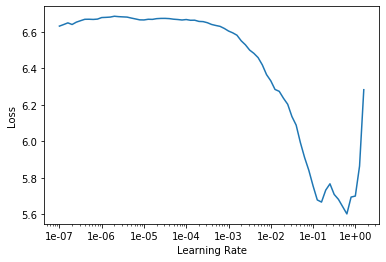

In [47]:
#find learning rate before starting the training of classifier
learn_clas_bwd.lr_find(start_lr=1e-8, end_lr=1e2)
learn_clas_bwd.recorder.plot()

In [56]:
learn_clas_bwd.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [0]:
learn_clas_bwd.freeze_to(-2)
learn_clas_bwd.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

In [57]:
learn_clas_bwd.freeze_to(-3)
learn_clas_bwd.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [53]:
learn_clas_bwd.unfreeze()
learn_clas_bwd.fit_one_cycle(1, slice(1e-5,1e-3), moms=(0.8,0.7))

RuntimeError: ignored

In [0]:
learn_clas_bwd.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [0]:
#Export the Learned Model
learn_clas_bwd.export('/content/drive/My Drive/Projects/AnalyticsHackathon/learned_classifer_try_2_bwd.pkl')

#Ensembling

In [0]:
pred_fwd,lbl_fwd = learn_clas_fwd.get_preds(ordered=True)
pred_bwd,lbl_bwd = learn_clas_bwd.get_preds(ordered=True)
final_pred = (pred_fwd+pred_bwd)/2

In [0]:
accuracy(final_pred, lbl_fwd)

tensor(0.9955)

#Analysis

In [0]:
learn_clas_fwd.data.classes

In [0]:
#Get the accuracy matrix 
predictions, targets = learn_clas_fwd.get_preds()

In [0]:
from sklearn import metrics

predictions_clas = np.argmax(predictions, axis = 1) 
print(predictions_clas)
print(targets)
predictions_clas_str = [ learn_clas_fwd.data.classes[thisPrediction] for thisPrediction in predictions_clas ]
targets_str = [ learn_clas_fwd.data.classes[thistarget] for thistarget in targets ]


tensor([149, 149, 149,  ..., 624, 624, 624])
tensor([147, 147, 147,  ..., 624, 624, 624])


In [0]:
#Generate Confusion Matrix
confusion_matrix = metrics.confusion_matrix(targets, predictions_clas)
print(confusion_matrix)

#Export Confustion Matrix
# df_confusion_matrix = pd.DataFrame(confusion_matrix)
# df_confusion_matrix.to_csv('/content/drive/My Drive/Projects/AnalyticsHackathon/ULMFit_Drug_Review_Confusion_Matrix_try1.csv')

[[1126    0    0    0 ...    0    0    0    0]
 [   0    2    0    0 ...    0    0    0    0]
 [   0    0  648    0 ...    0    0    0    0]
 [   0    0    0    2 ...    0    0    0    0]
 ...
 [   0    0    0    0 ...    3    0    0    0]
 [   0    0    0    0 ...    0    0    0    0]
 [   0    0    0    0 ...    0    0    3    0]
 [   0    0    0    0 ...    0    0    0    7]]


In [0]:
#From the confusion matrix, take diagnal elements

diag = np.diag(df_confusion_matrix)
correct_predictions = sum(diag)
total_validation_examples = np.sum(df_confusion_matrix, axis=1).sum()
pred_acc_percent = (correct_predictions/total_validation_examples) * 100
print(f"Sum of diagonal elements of the confusion matrix: {correct_predictions}")
print(f"Total number of vaildation examples: {total_validation_examples}")
print(f"Prediction Accuracy of the model: {pred_acc_percent}")


Sum of diagonal elements of the confusion matrix: 52906
Total number of vaildation examples: 53161
Prediction Accuracy of the model: 99.52032505031885


In [0]:
target_names = learn_clas_fwd.data.classes
print(metrics.classification_report(targets, predictions_clas, target_names=target_names))


                                                                precision    recall  f1-score   support

                                                          ADHD       1.00      1.00      1.00      1126
                                          AIDS Related Wasting       1.00      1.00      1.00         2
                                     Abnormal Uterine Bleeding       1.00      1.00      1.00       648
                                                      Abortion       1.00      1.00      1.00         2
                                        Acetaminophen Overdose       0.00      0.00      0.00         1
                                                          Acne       1.00      1.00      1.00      1847
                                             Actinic Keratosis       1.00      1.00      1.00         8
                                       Acute Coronary Syndrome       0.69      1.00      0.81        11
                                  Acute Lymphoblastic Leukemia 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
